# The distribution of track listening

In [1]:
import numpy as np
import pandas as pd
import featuretools as ft
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


In [2]:
log_df = pd.read_csv('../data/raw/data/training_set/log_mini.csv')

In [3]:
print(len(log_df['track_id_clean'].unique()), 'unique tracks were played.')

50704 unique tracks were played.


In [4]:
# the tracks with the highest number of play
log_df['track_id_clean'].value_counts()[0:10]

t_bacf06d3-9185-4183-84ea-ff0db51475ce    1427
t_5718ab08-3a15-4d3f-9e63-42b2f6805e31     915
t_8c4d29b1-e0bf-464c-88f7-ac19240cbba0     785
t_a66ea088-b357-449a-8a1e-64dd0b8d6cb5     730
t_77b02acb-1b1f-4b36-b8fc-2c3e01892b9a     719
t_9a31436c-a57a-4d7a-9bbc-50f0deca33de     612
t_0e3dec82-10b4-49f1-8c2e-cd19249f7d2c     600
t_2fd6279a-06cd-4d5d-9e54-1912f51bb3c3     593
t_7533e7ff-568e-448b-904e-fc0c3a9ec87e     576
t_29a3895e-2c91-49a6-9383-6a71c597390d     548
Name: track_id_clean, dtype: int64

In [5]:
play1 = (log_df['track_id_clean'].value_counts()==1).sum()/len(log_df['track_id_clean'].unique())*100
play5 = (log_df['track_id_clean'].value_counts()<=5).sum()/len(log_df['track_id_clean'].unique())*100
play10 = (log_df['track_id_clean'].value_counts()<=10).sum()/len(log_df['track_id_clean'].unique())*100

print('% of tracks only been played 1 time:',play1)
print('% of tracks only been played 5 times of less:',play5)
print('% of tracks only been played 10 times of less:',play10)

% of tracks only been played 1 time: 62.7623067213632
% of tracks only been played 5 times of less: 91.48193436415272
% of tracks only been played 10 times of less: 96.14034395708426


# Try clustering the tracks by their acoustic features

The idea of Collaborative Filtering is to look at the data of other similar sessions, as similar sessions should have similar skipping behavior.
However, as 91.5% of the tracks has only been played 5 times of less, the similar tracks have to be grouped into clusters to increase the likelyhood of overlapped groups of tracks across sessions.

In [6]:
tf_df = pd.read_csv('../data/raw/data/track_features/tf_mini.csv')
tf_df_dummy = pd.get_dummies(tf_df, columns=['key','time_signature','mode'])


In [7]:
from sklearn.preprocessing import StandardScaler

# only pick these columns to do the clustering
sel_col_names = ['acousticness','beat_strength','danceability',
                        'dyn_range_mean', 'energy', 'flatness','instrumentalness', 'liveness', 
                        'loudness', 'mechanism', 'organism','speechiness','valence',
                        'acoustic_vector_0','acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
                        'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6','acoustic_vector_7']
x_cols = tf_df_dummy[sel_col_names]

# rescale the data
scaler = StandardScaler()
x_cols_scaled = scaler.fit_transform(x_cols)


In [8]:
# # explore the optimal k

# from sklearn.cluster import KMeans
# inertia = []
# nClusters = []

# for k in range(20,205,5):
#     model = KMeans(n_clusters = k)
#     model.fit(x_cols_scaled)
#     inertia.append(model.inertia_)
#     nClusters.append(k)
    
# plt.plot(nClusters,inertia)
# plt.xlabel('K')
# plt.ylabel('SS')
# plt.show()

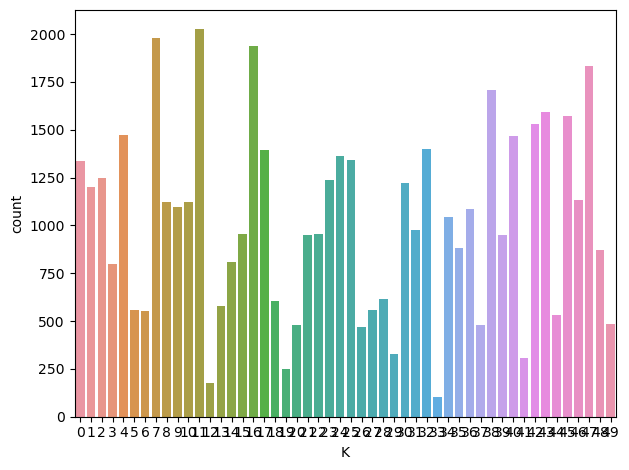

In [9]:
# KMeans
# k = 50 looks ok
km_model = KMeans(n_clusters = 50, random_state=23)
km_model.fit(x_cols_scaled)
clus = pd.DataFrame(km_model.predict(x_cols_scaled))
clus_count = pd.DataFrame(clus.value_counts(), columns = ['count']).reset_index()
clus_count
ax = sns.barplot(x = clus_count.iloc[:,0], y = clus_count['count'])
ax.set(xlabel='K', ylabel='count')
plt.tight_layout()
plt.show()

/Users/andrewchang/opt/anaconda3/envs/Springboard_DS_2022/lib/python3.8/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


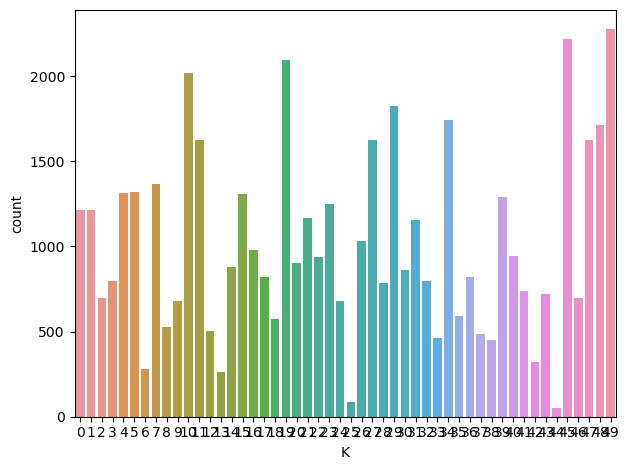

In [14]:
from sklearn.mixture import GaussianMixture
gm_model = GaussianMixture(n_components = 50, random_state=23)
gm_model.fit(x_cols_scaled)
clus = pd.DataFrame(gm_model.predict(x_cols_scaled))
clus_count = pd.DataFrame(clus.value_counts(), columns = ['count']).reset_index()
clus_count
ax = sns.barplot(x = clus_count.iloc[:,0], y = clus_count['count'])
ax.set(xlabel='K', ylabel='count')
plt.tight_layout()
plt.show()

In [10]:
# put the cluster label into the track dataframe
tf_df_dummy['clus'] = clus

In [11]:
# perform a simple dataframe join
df = log_df.merge(tf_df_dummy, left_on = 'track_id_clean', right_on = 'track_id')
df.sort_values(by = ['session_id', 'session_position'],inplace = True)
df.head().T

,0,45,50,327,353
session_id,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e
session_position,1,2,3,4,5
session_length,20,20,20,20,20
track_id_clean,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,t_64f3743c-f624-46bb-a579-0f3f9a07a123
skip_1,False,False,False,False,False
...,...,...,...,...,...
time_signature_4,1,1,1,1,1
time_signature_5,0,0,0,0,0
mode_major,1,0,1,1,1
mode_minor,0,1,0,0,0


In [12]:
df.to_csv('../data/processed/clustered_merged_20221121.csv')

## Recommendation Filtering

https://towardsdatascience.com/recommender-systems-item-customer-collaborative-filtering-ff0c8f41ae8a

https://github.com/DAR-DatenanalyseRehberg/RecommenderBinaryCF/blob/main/RecommenderCollaborativeFilteringDDDD.ipynb

In [12]:
# calculate the similarities among session based on first 80% of the tracks

df_train_append = []
train_perc = 0.8
for s_id in df['session_id'].unique():
    temp = []
    temp = df.loc[df['session_id']==s_id,:]
    df_train_append.append(temp.iloc[0:round(len(temp)*train_perc),:])

df_train = pd.concat(df_train_append)


In [13]:
# def cal_similarMat(df_train):
#     import numpy as np
#     import pandas as pd
    
#     sessions = list(np.sort(df_train['session_id'].unique())) 
#     tracks = list(df_train['clus'].unique()) 
#     no_skip_2 = (list(df_train['skip_2']==False))*1 # use *1 to convert bool to integer
    
#     DfSessionUnique = []
#     DfSessionUnique = pd.DataFrame(sessions,columns=['sessions'])
    
#     from scipy import sparse
#     from pandas.api.types import CategoricalDtype

#     rows = df_train['session_id'].astype(CategoricalDtype(categories=sessions)).cat.codes # unique sessions (index)

#     # Get the associated row indices
#     cols = df_train['clus'].astype(CategoricalDtype(categories=tracks)).cat.codes # unique tracks (column)
    
    
#     # Get the associated column indices
#     #Compressed Sparse Row matrix
#     listeningSparse = []
#     listeningSparse = sparse.csr_matrix((no_skip_2, (rows, cols)), shape=(len(sessions), len(tracks)))
#     #csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
#     #where data, row_ind and col_ind satisfy the relationship a[row_ind[k], col_ind[k]] = data[k]. , see https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

#     listeningSparse
#     #a sparse matrix is not a pandas dataframe, but sparse matrices are efficient for row slicing and fast matrix vector products
    
    
#     DataBinary = df_train.copy()
#     DataBinary['ListenYes'] = (DataBinary['skip_2'] == False)*1
    
#     data2=DataBinary[['session_id','clus','ListenYes']]

#     data2['ListenYes'].replace(0, -1, inplace = True)

#     data2['clus'] = 'c' + data2['clus'].astype(str)

#     data3 = data2.groupby(['session_id', 'clus']).agg({'ListenYes':['sum']})
#     data3 = data3.reset_index()
#     data3.columns = data3.columns.droplevel(level = 1) # take out the unwanted level
    
    
#     DfMatrix = pd.pivot_table(data3, values='ListenYes', index='session_id', columns='clus')

#     DfMatrix=DfMatrix.fillna(0) #NaN values need to get replaced by 0, meaning they have not been listened yet.
    
#     DfResetted = DfMatrix.reset_index().rename_axis(None, axis=1) 

#     DfTracksListen = DfResetted.drop(columns=['session_id'])

#     #Calculate the Item based recommendation
#     import numpy as np
#     DfTracksListenNorm = DfTracksListen / np.sqrt(np.square(DfTracksListen).sum(axis=0)) 

#     # Calculating with Vectors to compute Cosine Similarities
#     TrackTrackSim = DfTracksListenNorm.transpose().dot(DfTracksListenNorm) 

#     #Another approach to the above would be using correlation
#     TrackTrackCorr = DfTracksListenNorm.corr()

 

#     # Create a place holder matrix for similarities, and fill in the session column
#     SessTrackSimilarity = pd.DataFrame(index=DfResetted.index, columns=DfResetted.columns)
#     SessTrackSimilarity.iloc[:,:1] = DfResetted.iloc[:,:1]


#     #We now loop through the rows and columns filling in empty spaces with similarity scores.
    
#     SessionListening = []
#     TrackTopSimilarity = []

#     for i in range(0,len(SessTrackSimilarity.index)):
#         for j in range(1,len(SessTrackSimilarity.columns)):

#             ses = SessTrackSimilarity.index[i]
#             tra = SessTrackSimilarity.columns[j]

#             SessionListening = DfTracksListen.loc[ses,]
#             TrackSimilarity = TrackTrackSim[tra]
#             SessTrackSimilarity.loc[i][j] = sum(SessionListening*TrackSimilarity)/sum(TrackSimilarity)

#     end = timer()

#     print('\nRuntime: %0.2fs' % (end - start))
    
#     return SessTrackSimilarity



In [14]:
# from timeit import default_timer as timer #to see how long the computation will take
# start = timer()
# SessTrackSimilarity2 = cal_similarMat(df_train)
# end = timer()

In [15]:
sessions = list(np.sort(df_train['session_id'].unique())) 
tracks = list(df_train['clus'].unique()) 
no_skip_2 = (list(df_train['skip_2']==False))*1 # use *1 to convert bool to integer

In [16]:
DfSessionUnique = []
DfSessionUnique = pd.DataFrame(sessions,columns=['sessions'])
DfSessionUnique.head()

,sessions
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e
1,0_0000a72b-09ac-412f-b452-9b9e79bded8f
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a
3,0_00016a3d-9076-4f67-918f-f29e3ce160dc
4,0_00018b58-deb8-4f98-ac5e-d7e01b346130


In [17]:
from scipy import sparse
from pandas.api.types import CategoricalDtype

rows = df_train['session_id'].astype(CategoricalDtype(categories=sessions)).cat.codes # unique sessions (index)

# Get the associated row indices
cols = df_train['clus'].astype(CategoricalDtype(categories=tracks)).cat.codes # unique tracks (column)


In [18]:
# Get the associated column indices
#Compressed Sparse Row matrix
listeningSparse = []
listeningSparse = sparse.csr_matrix((no_skip_2, (rows, cols)), shape=(len(sessions), len(tracks)))
#csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
#where data, row_ind and col_ind satisfy the relationship a[row_ind[k], col_ind[k]] = data[k]. , see https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

listeningSparse
#a sparse matrix is not a pandas dataframe, but sparse matrices are efficient for row slicing and fast matrix vector products

<10000x50 sparse matrix of type '<class 'numpy.bool_'>'
	with 65592 stored elements in Compressed Sparse Row format>

In [19]:
#In terms of sparsity of the matrix, that makes:
MatrixSize = listeningSparse.shape[0]*listeningSparse.shape[1] # 130375 possible interactions in the matrix (10000 unique sessions * 50 unique clusters=500,000)
listeningAmount = len(listeningSparse.nonzero()[0]) # The actual number of interactions
sparsity = 100*(1 - (listeningAmount/MatrixSize))
print('sparsity:',sparsity)

sparsity: 92.1766


## Recommending

In [20]:
DataBinary = df_train.copy()
DataBinary['ListenYes'] = (DataBinary['skip_2'] == False)*1
DataBinary.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,key_11,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5,mode_major,mode_minor,clus,ListenYes
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,0,0,0,0,1,0,1,0,39,1
45,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,...,0,0,0,0,1,0,0,1,7,1
50,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,...,0,0,0,0,1,0,1,0,11,1
327,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,...,0,0,0,0,1,0,1,0,23,1
353,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,...,0,0,0,0,1,0,1,0,45,1


In [21]:
data2=DataBinary[['session_id','clus','ListenYes']]
data2.head(20)

,session_id,clus,ListenYes
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,39,1
45,0_00006f66-33e5-4de7-a324-2d18e439fc1e,7,1
50,0_00006f66-33e5-4de7-a324-2d18e439fc1e,11,1
327,0_00006f66-33e5-4de7-a324-2d18e439fc1e,23,1
353,0_00006f66-33e5-4de7-a324-2d18e439fc1e,45,1
475,0_00006f66-33e5-4de7-a324-2d18e439fc1e,43,1
537,0_00006f66-33e5-4de7-a324-2d18e439fc1e,43,0
540,0_00006f66-33e5-4de7-a324-2d18e439fc1e,43,0
541,0_00006f66-33e5-4de7-a324-2d18e439fc1e,7,0
601,0_00006f66-33e5-4de7-a324-2d18e439fc1e,32,0


In [22]:
# as 0 means these tracks were skipped, they should be coded as -1 to distinguish from the not encountered ones (0)
data2['ListenYes'].replace(0, -1, inplace = True)
data2.head(20)

,session_id,clus,ListenYes
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,39,1
45,0_00006f66-33e5-4de7-a324-2d18e439fc1e,7,1
50,0_00006f66-33e5-4de7-a324-2d18e439fc1e,11,1
327,0_00006f66-33e5-4de7-a324-2d18e439fc1e,23,1
353,0_00006f66-33e5-4de7-a324-2d18e439fc1e,45,1
475,0_00006f66-33e5-4de7-a324-2d18e439fc1e,43,1
537,0_00006f66-33e5-4de7-a324-2d18e439fc1e,43,-1
540,0_00006f66-33e5-4de7-a324-2d18e439fc1e,43,-1
541,0_00006f66-33e5-4de7-a324-2d18e439fc1e,7,-1
601,0_00006f66-33e5-4de7-a324-2d18e439fc1e,32,-1


In [23]:
#for better convenience we add 'c' for Item for every cluster.
data2['clus'] = 'c' + data2['clus'].astype(str)
data2.head(20)

,session_id,clus,ListenYes
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c39,1
45,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c7,1
50,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c11,1
327,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c23,1
353,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c45,1
475,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c43,1
537,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c43,-1
540,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c43,-1
541,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c7,-1
601,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c32,-1


In [24]:
data3 = data2.groupby(['session_id', 'clus']).agg({'ListenYes':['sum']})
data3 = data3.reset_index()
data3.columns = data3.columns.droplevel(level = 1) # take out the unwanted level
data3.head(20)

,session_id,clus,ListenYes
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c11,1
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c23,0
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c3,-1
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c32,-1
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c39,1
5,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c43,-2
6,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c45,1
7,0_00006f66-33e5-4de7-a324-2d18e439fc1e,c7,-1
8,0_0000a72b-09ac-412f-b452-9b9e79bded8f,c13,0
9,0_0000a72b-09ac-412f-b452-9b9e79bded8f,c18,-2


In [25]:
DfMatrix = pd.pivot_table(data3, values='ListenYes', index='session_id', columns='clus')

DfMatrix.head()

clus,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
session_id,,,,,,,,,,,,,,,,,,,,,
0_00006f66-33e5-4de7-a324-2d18e439fc1e,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
0_0000a72b-09ac-412f-b452-9b9e79bded8f,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,0.0,1.0,NaN,-3.0,NaN,NaN,NaN,NaN,2.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
0_00016a3d-9076-4f67-918f-f29e3ce160dc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
0_00018b58-deb8-4f98-ac5e-d7e01b346130,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [26]:
DfMatrix=DfMatrix.fillna(0) #NaN values need to get replaced by 0, meaning they have not been listened yet.
DfMatrix

clus,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
session_id,,,,,,,,,,,,,,,,,,,,,
0_00006f66-33e5-4de7-a324-2d18e439fc1e,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
0_0000a72b-09ac-412f-b452-9b9e79bded8f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,0.0,1.0,0.0,-3.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
0_00016a3d-9076-4f67-918f-f29e3ce160dc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
0_00018b58-deb8-4f98-ac5e-d7e01b346130,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0_0eac164c-f209-4590-8608-a56e67658952,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-2.0,0.0,...,-2.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0_0eacbee7-9868-48a0-9ab0-f86069329f50,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,0.0,0.0
0_0ead11fc-f32c-4eb4-8fc1-15b51432a404,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [27]:
DfMatrixNorm3 = (DfMatrix-DfMatrix.min())/(DfMatrix.max()-DfMatrix.min())
DfMatrixNorm3.head()


clus,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
session_id,,,,,,,,,,,,,,,,,,,,,
0_00006f66-33e5-4de7-a324-2d18e439fc1e,0.5000,0.464286,0.533333,0.588235,0.357143,0.388889,0.526316,0.428571,0.375000,0.521739,...,0.347826,0.347826,0.444444,0.555556,0.421053,0.4375,0.4,0.40,0.411765,0.533333
0_0000a72b-09ac-412f-b452-9b9e79bded8f,0.5000,0.464286,0.533333,0.529412,0.357143,0.388889,0.526316,0.428571,0.375000,0.521739,...,0.304348,0.347826,0.444444,0.500000,0.421053,0.4375,0.4,0.44,0.411765,0.533333
0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,0.5000,0.500000,0.533333,0.352941,0.357143,0.388889,0.526316,0.428571,0.458333,0.521739,...,0.304348,0.347826,0.444444,0.555556,0.421053,0.4375,0.4,0.40,0.411765,0.533333
0_00016a3d-9076-4f67-918f-f29e3ce160dc,0.5000,0.464286,0.533333,0.529412,0.357143,0.388889,0.526316,0.428571,0.375000,0.173913,...,0.304348,0.347826,0.444444,0.555556,0.421053,0.4375,0.4,0.44,0.411765,0.666667
0_00018b58-deb8-4f98-ac5e-d7e01b346130,0.4375,0.464286,0.533333,0.529412,0.357143,0.388889,0.526316,0.428571,0.375000,0.521739,...,0.304348,0.391304,0.555556,0.555556,0.421053,0.4375,0.4,0.44,0.470588,0.533333


In [28]:
#we need to bring our pivot table into the desired format, via reset_index and rename_axis. 
DfResetted = DfMatrix.reset_index().rename_axis(None, axis=1) 
DfResetted.head()
#Now each row represents one customer`s buying behaviour: 1 means the customer has purchased, NaN the customer has not yet purchased it

,session_id,c0,c1,c10,c11,c12,c13,c14,c15,c16,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
1,0_0000a72b-09ac-412f-b452-9b9e79bded8f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,0.0,1.0,0.0,-3.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
3,0_00016a3d-9076-4f67-918f-f29e3ce160dc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0_00018b58-deb8-4f98-ac5e-d7e01b346130,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
DfMatrix.shape

(10000, 50)

In [30]:
DfTracksListen = DfResetted.drop(columns=['session_id'])
DfTracksListen.head()

,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,-3.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
#Calculate the Item based recommendation
import numpy as np
DfTracksListenNorm = DfTracksListen / np.sqrt(np.square(DfTracksListen).sum(axis=0)) 
DfTracksListenNorm.head()

,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
0,0.000000,0.000000,0.0,0.008778,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.010547,0.000000,0.000000,0.00000,0.0,0.0,0.0,-0.006038,0.000000,0.000000
1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.000000,0.000000,0.000000,-0.01947,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0.000000,0.009071,0.0,-0.026335,0.0,0.0,0.0,0.0,0.01893,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,-0.006038,0.000000,0.000000
3,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,-0.095714,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.039322
4,-0.015659,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.000000,0.017337,0.019055,0.00000,0.0,0.0,0.0,0.000000,0.018765,0.000000


In [32]:
# Calculating with Vectors to compute Cosine Similarities
TrackTrackSim = DfTracksListenNorm.transpose().dot(DfTracksListenNorm) 
TrackTrackSim.head()

,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
c0,1.000000,0.016335,0.000251,0.109284,0.027862,0.015400,0.009486,0.103815,0.105532,0.006932,...,0.074155,0.024977,0.102201,0.005183,-0.001414,0.020117,0.000953,0.124140,0.004995,0.017241
c1,0.016335,1.000000,0.006967,0.039654,0.000489,0.004212,0.022168,0.021381,0.033655,0.001411,...,0.016072,0.007391,0.057730,0.003179,-0.000819,-0.000920,0.000920,0.025247,0.005957,0.002853
c10,0.000251,0.006967,1.000000,0.001686,0.001726,0.003060,0.004345,-0.001572,0.003484,0.002298,...,0.001857,-0.001942,-0.000915,0.006231,0.006261,0.000541,0.000000,0.002319,0.001501,0.000000
c11,0.109284,0.039654,0.001686,1.000000,0.004733,0.006715,0.021086,0.122859,0.195258,0.009137,...,0.122025,0.029525,0.105132,0.006153,0.005284,0.019586,0.007657,0.244918,0.028662,0.026751
c12,0.027862,0.000489,0.001726,0.004733,1.000000,0.001473,0.010136,0.023829,0.015310,0.003225,...,0.017628,0.021499,0.004110,0.006298,-0.003245,0.003645,0.004375,0.009115,0.016188,0.007420


In [33]:
#Another approach to the above would be using correlation
TrackTrackCorr = DfTracksListenNorm.corr()
TrackTrackCorr.head()

,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
c0,1.000000,0.014606,0.000100,0.105528,0.025061,0.014372,0.008602,0.102338,0.101627,0.006551,...,0.069212,0.023826,0.101920,0.004717,-0.001330,0.019900,0.002575,0.121763,0.003811,0.016873
c1,0.014606,1.000000,0.006919,0.038305,-0.000489,0.003853,0.021869,0.020792,0.032249,0.001276,...,0.014317,0.006982,0.057563,0.003018,-0.000790,-0.001011,0.001467,0.024329,0.005555,0.002715
c10,0.000100,0.006919,1.000000,0.001567,0.001644,0.003030,0.004320,-0.001623,0.003365,0.002286,...,0.001708,-0.001977,-0.000931,0.006218,0.006264,0.000533,0.000046,0.002240,0.001467,-0.000012
c11,0.105528,0.038305,0.001567,1.000000,0.002417,0.005867,0.020393,0.121673,0.192429,0.008832,...,0.118272,0.028599,0.104869,0.005778,0.005363,0.019403,0.008974,0.243268,0.027752,0.026465
c12,0.025061,-0.000489,0.001644,0.002417,1.000000,0.000885,0.009644,0.022875,0.012942,0.003008,...,0.014751,0.020848,0.003809,0.006039,-0.003200,0.003500,0.005271,0.007590,0.015543,0.007199


In [34]:
# Create a placeholder items for closes neighbours to an item
TrackNeighbours = pd.DataFrame(index=TrackTrackSim.columns,columns=range(1,51))
TrackNeighbours.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
c0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# Create a placeholder items for closes neighbours to an item
# Loop through our similarity dataframe and fill in neighbouring item names
for i in range(0,len(TrackTrackSim.columns)):
    TrackNeighbours.iloc[i,:50] = TrackTrackSim.iloc[0:,i].sort_values(ascending=False)[:50].index
TrackNeighbours

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
c0,c0,c43,c4,c3,c7,c24,c11,c16,c39,c15,...,c36,c34,c19,c6,c10,c33,c18,c35,c49,c41
c1,c1,c23,c47,c44,c11,c39,c40,c16,c43,c25,...,c6,c27,c12,c29,c33,c19,c49,c5,c20,c41
c10,c10,c25,c35,c44,c1,c29,c49,c48,c34,c14,...,c20,c6,c9,c26,c2,c47,c19,c15,c46,c37
c11,c11,c7,c23,c16,c43,c24,c32,c15,c45,c3,...,c12,c35,c29,c36,c34,c25,c19,c10,c20,c33
c12,c12,c4,c18,c21,c3,c27,c0,c33,c26,c15,...,c10,c13,c44,c25,c1,c29,c38,c28,c49,c41
c13,c13,c2,c22,c42,c38,c8,c20,c31,c37,c29,...,c1,c10,c32,c27,c12,c43,c25,c6,c33,c35
c14,c14,c36,c31,c34,c40,c17,c9,c48,c5,c21,...,c30,c37,c25,c38,c10,c6,c41,c19,c33,c35
c15,c15,c3,c24,c23,c11,c7,c43,c0,c47,c16,...,c19,c13,c6,c38,c41,c33,c25,c34,c35,c10
c16,c16,c7,c11,c45,c32,c43,c4,c23,c39,c0,...,c22,c10,c44,c49,c41,c19,c38,c25,c33,c20
c17,c17,c2,c42,c31,c36,c9,c48,c14,c34,c21,...,c28,c10,c35,c1,c5,c29,c33,c6,c41,c19


In [36]:
# Create a place holder matrix for similarities, and fill in the session column
SessTrackSimilarity = pd.DataFrame(index=DfResetted.index, columns=DfResetted.columns)
SessTrackSimilarity.iloc[:,:1] = DfResetted.iloc[:,:1]
SessTrackSimilarity.head()

,session_id,c0,c1,c10,c11,c12,c13,c14,c15,c16,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0_0000a72b-09ac-412f-b452-9b9e79bded8f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0_00016a3d-9076-4f67-918f-f29e3ce160dc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0_00018b58-deb8-4f98-ac5e-d7e01b346130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
#We now loop through the rows and columns filling in empty spaces with similarity scores.
from timeit import default_timer as timer #to see how long the computation will take
start = timer()
SessionListening = []
TrackTopSimilarity = []

for i in range(0,len(SessTrackSimilarity.index)):
    for j in range(1,len(SessTrackSimilarity.columns)):

        ses = SessTrackSimilarity.index[i]
        tra = SessTrackSimilarity.columns[j]
        
        SessionListening = DfTracksListen.loc[ses,]
        TrackSimilarity = TrackTrackSim[tra]
        SessTrackSimilarity.loc[i][j] = sum(SessionListening*TrackSimilarity)/sum(TrackSimilarity)

end = timer()

print('\nRuntime: %0.2fs' % (end - start))



Runtime: 120.89s


In [38]:
SessTrackSimilarity

,session_id,c0,c1,c10,c11,c12,c13,c14,c15,c16,...,c45,c46,c47,c48,c49,c5,c6,c7,c8,c9
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,-0.119902,-0.0066,-0.0054,0.110831,-0.02636,0.014126,0.004284,-0.106707,-0.108281,...,0.164862,-0.020056,-0.004405,0.002821,-0.00059,0.001554,0.006624,-0.373441,-0.000111,-0.004157
1,0_0000a72b-09ac-412f-b452-9b9e79bded8f,0.02702,0.000203,-0.006247,0.010468,-0.063611,-0.046553,-0.100083,0.013559,0.008052,...,-0.005029,-0.0109,0.059841,-0.675059,-0.105175,0.008656,-0.013601,0.013383,-0.066023,-0.067655
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,-0.068601,0.597445,0.007853,-0.736614,-0.005419,0.005815,0.007465,-0.082676,0.429948,...,0.012699,-0.008812,-0.006525,0.001867,-0.002741,-0.001796,-0.005829,-0.253353,-0.016919,-0.00455
3,0_00016a3d-9076-4f67-918f-f29e3ce160dc,-0.06682,-0.030465,-0.012079,-0.041585,-0.024875,-0.171131,-0.194995,-0.050483,-0.050787,...,-0.033743,-0.214019,-0.237338,-0.230561,-0.041382,0.008878,0.006192,-0.045007,-0.078002,0.360526
4,0_00018b58-deb8-4f98-ac5e-d7e01b346130,-0.175411,0.139948,0.002624,0.112712,0.041888,0.084743,0.167012,0.155042,0.096646,...,0.067232,0.600157,0.908952,0.044708,0.043264,0.0868,0.014527,0.066327,0.502593,0.219568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0_0eac164c-f209-4590-8608-a56e67658952,-0.663342,-0.228499,-0.015783,-0.698341,-0.086319,-0.116776,-0.5777,-0.621996,-0.960346,...,-1.026297,-0.183578,-0.606362,-0.048676,-0.047635,-0.210729,-0.047784,-0.55993,-0.160849,-0.172764
9996,0_0eacbee7-9868-48a0-9ab0-f86069329f50,-0.719342,-0.15986,-0.013107,-0.570099,-0.084691,-0.029075,-0.066646,-0.672561,-0.585712,...,-0.602022,-0.124782,-0.216477,-0.011749,-0.009548,-0.087765,-0.010532,-1.67528,-0.081701,-0.07263
9997,0_0ead11fc-f32c-4eb4-8fc1-15b51432a404,0.273473,-0.063655,-0.003605,-0.306477,-0.018451,-0.015023,-0.052503,-0.016969,-0.135967,...,-0.961144,-0.02558,-0.048294,-0.013592,-0.017104,-0.028481,-0.017253,0.092648,-0.031494,-0.022439
9998,0_0eae096d-ae4c-4556-8227-0f6294958330,-0.005156,-0.008095,-0.000408,-0.010691,-0.05171,-0.027931,-0.049777,-0.013263,-0.00765,...,-0.013281,-0.036035,-0.010845,0.197442,-0.023823,-0.005411,-0.003283,-0.00557,-0.064219,-0.075162


In [39]:
SessTrackSimilarity.to_csv('../data/processed/SessTrackSimilarity_20221121.csv')

In [251]:
# perform a simple dataframe join
df2 = df.merge(SessTrackSimilarity, left_on = 'session_id', right_on = 'session_id')
df2.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
session_id,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e
session_position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
session_length,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
track_id_clean,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,t_c815228b-3212-4f9e-9d4f-9cb19b248184,t_e23c19f5-4c32-4557-aa44-81372c2e3705,t_0be6eced-f56f-48bd-8086-f2e0b760fdee,t_f3ecbd3b-9e8e-4557-b8e0-39cfcd7e65dd,t_2af4dfa0-7df3-4b7e-b7ab-353ba48237f9,t_79570b2a-639a-4ec0-9853-71c5299ac44d,t_69016f19-84aa-40c0-afa9-54404397b7a2,t_59dc3fcd-7aec-4da5-a747-b59b19bab3bb,t_a157ba98-7eae-4e7d-99d5-ed760b2c0978,t_87d95b75-af5c-4ef6-8dc4-cd888ae17cce,t_db945033-3dc5-4a22-8889-c72fd2781299,t_bff5b6c6-6968-41be-b723-7e860b372975,t_bf496d77-9eb2-4fe1-80f7-2c7ecd6f9b8e,t_1051bc37-1a73-4301-812b-f83ae0c9bbcd,t_358c9cce-7a1e-4dd4-81de-206dda80363f
skip_1,False,False,False,False,False,False,True,True,False,True,True,True,True,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c5,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391
c6,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515
c7,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024
c8,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074


In [252]:
df2.to_csv('../data/processed/recomFilter_20221121.csv')